In [1]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [2]:
#Setting the options

#load population data
population_names = pd.read_csv('oryx_pop_info_sorted_46_final.txt', sep='\t', header=0)
#load the covariance matrix
filename='oryx_6xyh_1K.cov'
cov_mat= pd.read_csv(filename, sep=' ', header=None)
#define number of principal components to be used as inputs for UMAP and t-SNE calculations
n_pc = 5
#define parameter range for t-SNE
perplexity_values=(10,20,30,40)
#define parameter space for UMAP
mindists=(0.001,0.01,0.1,0.5)
n_neighbors_nums=(5,10,20)


Elbow point (optimal number of components): 8


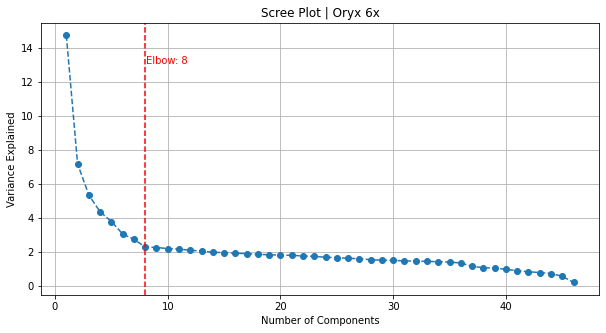

Elbow point (optimal number of components): 4


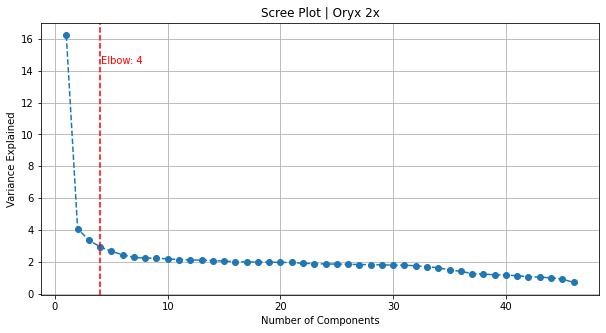

Elbow point (optimal number of components): 2


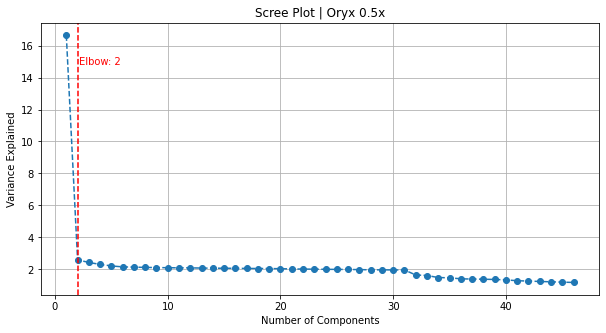

Elbow point (optimal number of components): 6


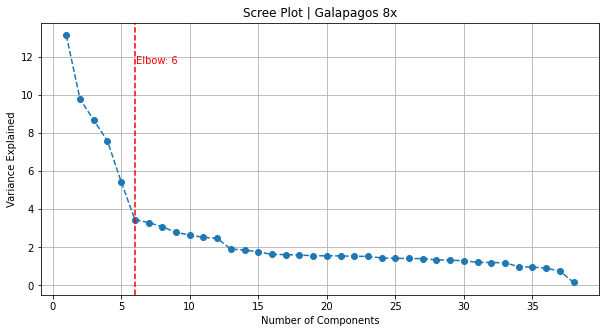

Elbow point (optimal number of components): 6


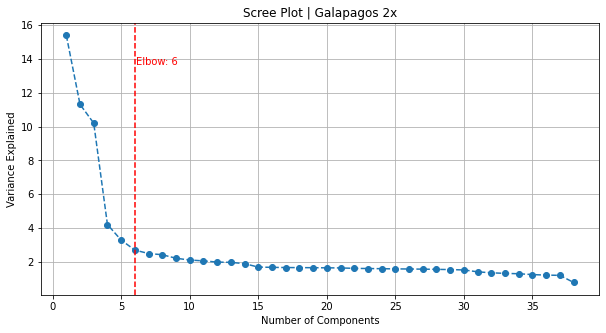

Elbow point (optimal number of components): 2


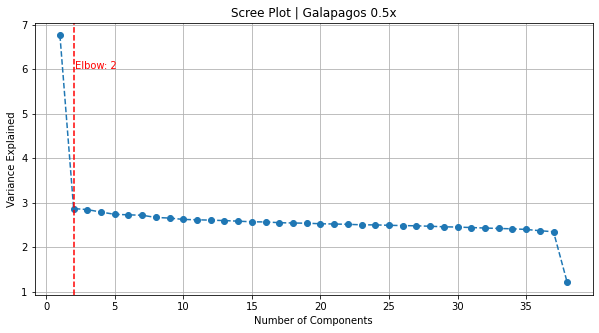

In [26]:
# Define your filenames and their corresponding titles
filenames = ['oryx_6xyh_1K.cov', 'oryx_2xyh_1K.cov', 'oryx_0.5xyh_1K.cov', 'galap_8x_1K.cov', 'galap_2x_1K.cov', 'galap_0.5x_1K.cov']
filename_titles = ['Oryx 6x', 'Oryx 2x', 'Oryx 0.5x', 'Galapagos 8x', 'Galapagos 2x', 'Galapagos 0.5x']  # Replace these with your actual titles
method='interp1d' # 'polynomial' or 'interp1d'

def plot_scree(explained_variance,save_filename,elbow_point):
    plt.figure(figsize=(10, 5))
    # Convert to a simple list if it's not already
    explained_variance = list(explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.axvline(x=elbow_point, color='r', linestyle='--')
    plt.text(elbow_point + 0.1, max(explained_variance) * 0.9, f'Elbow: {elbow_point}', color='red', verticalalignment='center')
    plt.title(f'Scree Plot | {filename_titles[i]}')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.grid()
    plt.savefig(save_filename, format='png')
    plt.show()

# Function to find the elbow point
def find_elbow_point(explained_variance, sensitivity=1.0):
    explained_variance = list(explained_variance)
    kneedle = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, 
                          curve='convex', direction='decreasing', 
                          S=sensitivity, interp_method=method)
    return kneedle.elbow

# Loop through each file and plot
for i, filename in enumerate(filenames):
    # Load the covariance matrix for each file
    cov_mat = pd.read_csv(filename, sep=' ', header=None)
    
    #convert covariance matrix to numpy array
    cov_mat_np=cov_mat.to_numpy()

    # calculate eigen vectors and eigen values from the initial covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)
    feature_vector = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(len(eigen_vals))])
    principal_components = cov_mat_np.dot(feature_vector) 

    # sorting them from largest to smallest
    idx = eigen_vals.argsort()[::-1]   
    eigenValues = eigen_vals[idx]
    eigenVectors = eigen_vecs[:,idx]

    # calculating the total explained variance
    expl_pre=eigenValues/sum(eigenValues)
    expl=np.cumsum(expl_pre)

    expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
    expl_df['cumulative_expl']=expl*100
    expl_df.set_index(np.arange(1, eigenVectors.shape[0] + 1), inplace=True)

    # Plot the scree plot
    plot_filename = f'scree_plot_{method}_{filename_titles[i].replace(" ", "_")}.png'

    # Find the elbow point
    elbow_point = find_elbow_point(expl_df['explained_variance'])
    print("Elbow point (optimal number of components):", elbow_point)

    plot_scree(expl_df['explained_variance'],plot_filename,elbow_point)




In [9]:
#convert covariance matrix to numpy array
cov_mat_np=cov_mat.to_numpy()

# calculate eigen vectors and eigen values from the initial covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
feature_vector = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(len(eigen_vals))])
principal_components = cov_mat_np.dot(feature_vector) 

# sorting them from largest to smallest
idx = eigen_vals.argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vecs[:,idx]

# calculating the total explained variance
expl_pre=eigenValues/sum(eigenValues)
expl=np.cumsum(expl_pre)

expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
expl_df['cumulative_expl']=expl*100
expl_df.set_index(np.arange(1, eigenVectors.shape[0] + 1), inplace=True)


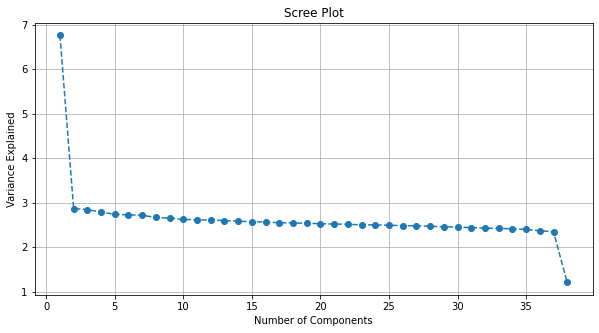

Elbow point (optimal number of components): 4


In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Function to plot the scree plot
def plot_scree(explained_variance):
    plt.figure(figsize=(10, 5))
    # Convert to a simple list if it's not already
    explained_variance = list(explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.grid()
    plt.show()

# Function to find the elbow point
def find_elbow_point(explained_variance, sensitivity=1.0):
    explained_variance = list(explained_variance)
    kneedle = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, 
                          curve='convex', direction='decreasing', 
                          S=sensitivity, interp_method='polynomial')
    return kneedle.elbow

# Plot the scree plot
plot_scree(expl_df['explained_variance'])

# Find the elbow point
elbow_point = find_elbow_point(expl_df['explained_variance'])
print("Elbow point (optimal number of components):", elbow_point)

# Using elbow point for further analysis
n_pc = elbow_point  # Update the number of principal components

